In [149]:
import pandas as pd
import numpy as np
import retrieval_311
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns

import matplotlib.ticker as mtick
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

In [150]:
df = retrieval_311.process_data()

Data available locally
Processing data


In [151]:
scaler = StandardScaler()

In [152]:
normalized = scaler.fit_transform(df[['calls']])

In [153]:
normalized_df = pd.DataFrame(normalized, index=df.index, columns=["normalized_calls"])

In [154]:
df['year'] = df.index.year

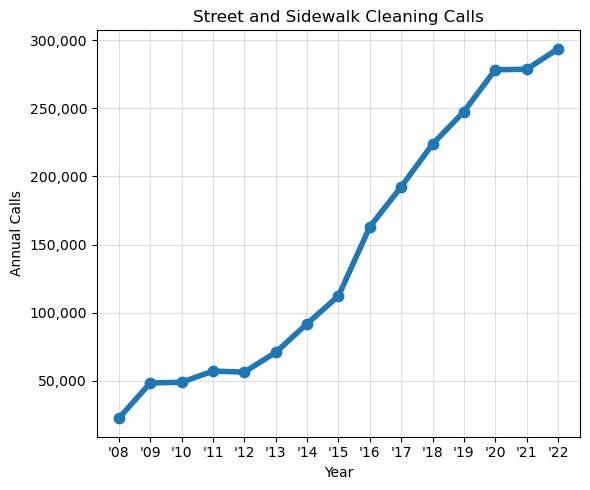

In [155]:
year_group = df.groupby("year")['calls'].sum()
year_group = year_group.iloc[:-1]

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(year_group, ".-", linewidth=4, markersize=15)
ax.set_xticks(year_group.index)
ax.set_xticklabels(["'"+str(y)[-2:] for y in year_group.index])
ax.grid(alpha=.4)
fmt = '{x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick)
ax.set(title="Street and Sidewalk Cleaning Calls", xlabel="Year", ylabel="Annual Calls")
fig.tight_layout()
fig.savefig("figures/annual_trend.png", dpi=300)

In [156]:
df['date'] = df.index.date

In [169]:
all_years = df.index.year.unique()

rmses = []
r2s = []
max_resids = []
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = df[df.index.year == all_years[i]]
    test_data = df[df.index.year == all_years[i+1]]
    preds = (train_data
             .groupby(['date', 'hourofday'])
             ['calls']
             .max()).to_dict()
    test_preds = (
        test_data
        .apply(lambda x: preds.get(((x.date - pd.DateOffset(years=1)).to_pydatetime().date(),
                                    x.hourofday)),
                axis=1)
    )
    print(test_preds.isna().sum())
    rmse = np.mean((test_data['calls'] - test_preds)**2)**.5
    # r2 = r2_score(test_data['calls'], test_preds, )
    max_resid = np.max(np.abs(test_data['calls'] - test_preds))
    print("rmse", rmse)
    # print("r2", r2)
    print("max resid", max_resid)
    rmses.append(rmse)
    # r2s.append(r2)
    max_resids.append(max_resid)
print("Mean RMSE:", np.mean(rmses))
# print("Mean r2:", np.mean(r2s))
print("Max resid:", np.mean(max_resids))
    

2008 --> 2009
4344
rmse 5.1728282567579065
max resid 31.0
2009 --> 2010
0
rmse 5.217758139277826
max resid 39
2010 --> 2011
0
rmse 5.795605326097561
max resid 42
2011 --> 2012
0
rmse 6.466152942807757
max resid 122
2012 --> 2013
0
rmse 6.95187304348874
max resid 133
2013 --> 2014
0
rmse 8.262889474375983
max resid 165
2014 --> 2015
0
rmse 9.385485004363028
max resid 156
2015 --> 2016
0
rmse 14.259292180155818
max resid 119
2016 --> 2017
0
rmse 13.990146565109388
max resid 109
2017 --> 2018
0
rmse 15.254264318828222
max resid 238
2018 --> 2019
0
rmse 16.42508244525224
max resid 260
2019 --> 2020
0
rmse 18.65720510601579
max resid 295
2020 --> 2021
0
rmse 20.506795287612263
max resid 465
2021 --> 2022
0
rmse 21.233787798982956
max resid 482
Mean RMSE: 11.96994042065182
Max resid: 189.71428571428572


In [43]:
all_years = df.index.year.unique()

rmses = []
for i in range(len(all_years)-2):
    print(all_years[i], "-->", all_years[i+1])
    train_data = df[df.index.year == all_years[i]]
    test_data = df[df.index.year == all_years[i+1]]
    preds = (train_data
             .groupby([train_data['month'],
                       train_data['dayofmonth'],
                       train_data['hourofday']])
             ['calls']
             .max()).to_dict()
    test_preds = (
        test_data
        .apply(lambda x: preds.get((x.month,
                                    x.dayofmonth,
                                    x.hourofday)),
                axis=1)
    )
    rmse = np.mean((test_data['calls'] - test_preds)**2)**.5
    print(rmse)
    rmses.append(rmse)
print("Mean RMSE:", np.mean(rmses))
    

2008 --> 2009
5.1728282567579065
2009 --> 2010
5.217758139277826
2010 --> 2011
5.795605326097561
2011 --> 2012
6.470039839530678
2012 --> 2013
6.95187304348874
2013 --> 2014
8.262889474375983
2014 --> 2015
9.385485004363028
2015 --> 2016
14.222474015560291
2016 --> 2017
13.990146565109388
2017 --> 2018
15.254264318828222
2018 --> 2019
16.42508244525224
2019 --> 2020
18.67816223005458
2020 --> 2021
20.506795287612263
2021 --> 2022
21.233787798982956
Mean RMSE: 11.969085124663689


In [201]:
lags = 3
X_ = df.copy()[['calls']]
for i in range(1, lags+1):
    X_[f'lag_{i}'] = X_['calls'].shift(i)

In [203]:
X = X_.dropna().drop('calls', axis=1).values

In [206]:
y = X_.dropna()['calls'].values

In [212]:
train_ind = int(len(y)*.8)

In [214]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM


n_steps = 3

# split the input data into training and testing sets
X_train, X_test = X[:train_ind], X[train_ind:]
Y_train, Y_test = y[:train_ind], y[train_ind:]

# define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit the model to the training data
model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), Y_train, epochs=3, batch_size=4)

# make predictions for test data
predictions = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# calculate root mean square error (RMSE) of predictions
rmse = np.sqrt(np.mean((predictions - Y_test)**2))
print("RMSE:", rmse)

Epoch 1/3
25876/25876 [==============================] - 41s 2ms/step - loss: 80.6008
Epoch 2/3
25876/25876 [==============================] - 40s 2ms/step - loss: 77.3890
Epoch 3/3
809/809 [==============================] - 3s 3ms/step
RMSE: 40.69509112388042
